## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch as tch
%matplotlib inline


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

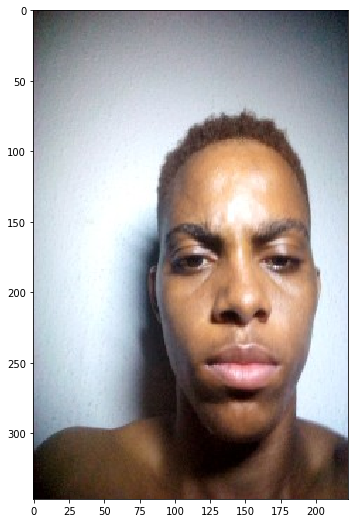

In [102]:
import cv2
# load in color image for face detection
image = cv2.imread('images/B1079047_Oct-18-2019_02-49-38.jpeg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


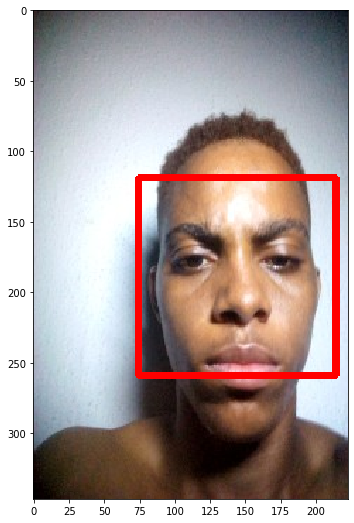

In [103]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2,5)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [89]:
# ## TODO: define the convolutional neural network architecture

# import torch
# from torch.autograd import Variable
# import torch.nn as nn
# import torch.nn.functional as F
# # can use the below import should you choose to initialize the weights of your Net
# import torch.nn.init as I
# from collections import OrderedDict

# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
        
#         ## TODO: Define all the layers of this CNN, the only requirements are:
#         ## 1. This network takes in a square (same width and height), grayscale image as input
#         ## 2. It ends with a linear layer that represents the keypoints
#         ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
#         # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
#         # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        
#         #Conv layer
        
#         self.feature = nn.Sequential(OrderedDict([#('batch_norm1', nn.BatchNorm2d(1)),
#                                                    ('conv1_0', nn.Conv2d(1, 32, 5)),
#                                                    ('relu1_0', nn.ReLU()),
#                                                    #('avg1_0',  nn.MaxPool2d((3,3), stride=3)),
#                                                    #('batch_norm2', nn.BatchNorm2d(32)),
#                                                    ('conv1_1',  nn.Conv2d(32, 64, 5)),
#                                                    ('relu1_1', nn.ReLU()),
#                                                    ('batch_norm3', nn.BatchNorm2d(64)),
#                                                    ('avg1_1',  nn.MaxPool2d((3,3), stride=3)),
#                                                    ('drop0', nn.Dropout2d(0.5)),
#                                                    ('conv1_2',  nn.Conv2d(64, 150, 5)),
#                                                    ('relu1_2', nn.ReLU()),
#                                                    #('batch_norm4', nn.BatchNorm2d(150)),
#                                                    #('maxp1_2',  nn.MaxPool2d((2,2), stride=2)),
#                                                    ('conv2_0',  nn.Conv2d(150, 400, 3)),
#                                                    ('relu2_0', nn.ReLU()),
#                                                    ('batch_norm5', nn.BatchNorm2d(400)),
#                                                    ('avg2_0',  nn.MaxPool2d((3,3), stride=3)),
                                                   
#                                                    ('conv2_1',  nn.Conv2d(400, 1000, 3)),
#                                                    ('relu2_1', nn.ReLU()),
# #                                                    ('avg2_1',  nn.MaxPool2d((2,2), stride=1)),
# #                                                    ('batch_norm6', nn.BatchNorm2d(140)),
#                                                    ('drop1', nn.Dropout2d(0.25)),
#                                                    ('conv2_2',  nn.Conv2d(1000, 300, 2)),
#                                                    ('relu2_2', nn.ReLU()),
#                                                    ('avg2_2', nn.MaxPool2d((3,3), stride=3))
#                                                    ]))
#         self.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(10800, 136))]))
        
#         ## Note that among the layers to add, consider including:
#         # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        
        
#     def forward(self, x):
#         ## TODO: Define the feedforward behavior of this model
#         ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        
#         # first feature pooling
#         x = self.fc(self.feature(x).view((-1, 10800)))
#         return x


In [106]:
# ## TODO: load the best saved model parameters (by your path name)
# ## You'll need to un-comment the line below and add the correct name for *your* saved model

# ## TODO: define the convolutional neural network architecture

# import torch
# from torch.autograd import Variable
# import torch.nn as nn
# import torch.nn.functional as F
# # can use the below import should you choose to initialize the weights of your Net
# import torch.nn.init as I
# from collections import OrderedDict

# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
        
#         ## TODO: Define all the layers of this CNN, the only requirements are:
#         ## 1. This network takes in a square (same width and height), grayscale image as input
#         ## 2. It ends with a linear layer that represents the keypoints
#         ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
#         # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
#         # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        
#         #Conv layer
        
#         self.feature1 = nn.Sequential(OrderedDict([('batch_norm1', nn.BatchNorm2d(1)),
#                                                    ('conv1_0', nn.Conv2d(1, 32, 5)),
#                                                    ('relu1_0', nn.ReLU()),
#                                                    ('batch_norm2', nn.BatchNorm2d(32)),
#                                                    ('avg1_0',  nn.MaxPool2d((3,3), stride=3)),
#                                                    ('conv1_1',  nn.Conv2d(32, 64, 5)),
#                                                    ('relu1_1', nn.ReLU()),
#                                                    ('batch_norm3', nn.BatchNorm2d(64)),
#                                                    ('avg1_1',  nn.MaxPool2d((2,2), stride=2)),
#                                                    ('conv1_2',  nn.Conv2d(64, 150, 5)),
#                                                    ('relu1_2', nn.ReLU()),
#                                                    ('batch_norm4', nn.BatchNorm2d(150)),
#                                                    ('maxp1_2',  nn.MaxPool2d((2,2), stride=2)),
#                                                    ('conv2_0',  nn.Conv2d(150, 148, 3)),
#                                                    ('relu2_0', nn.ReLU()),
#                                                    ('batch_norm5', nn.BatchNorm2d(148)),
#                                                    ('avg2_0',  nn.MaxPool2d((3,3), stride=3)),
#                                                    ('conv2_1',  nn.Conv2d(148, 140, 3)),
#                                                    ('relu2_1', nn.ReLU()),
#                                                    #('avg2_1',  nn.MaxPool2d((2,2), stride=1)),
#                                                    ('batch_norm6', nn.BatchNorm2d(140)),
#                                                    ('conv2_2',  nn.Conv2d(140, 136, 2)),
#                                                    ]))

        
        
#         ## Note that among the layers to add, consider including:
#         # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        
        
#     def forward(self, x):
#         ## TODO: Define the feedforward behavior of this model
#         ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        
#         # first feature pooling
#         x = self.feature1(x).view(x.shape[0],-1)
#         return x

from models import Net    
import torch
model = torch.load('./saved_models/keypoints_model_frt_tst10.pth')
net = model['arc']
net.load_state_dict(model['state_dict'])
## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (feature1): Sequential(
    (batch_norm1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (relu1_0): ReLU()
    (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avg1_0): MaxPool2d(kernel_size=(3, 3), stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv1_1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (relu1_1): ReLU()
    (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avg1_1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1_2): Conv2d(64, 150, kernel_size=(5, 5), stride=(1, 1))
    (relu1_2): ReLU()
    (batch_norm4): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxp1_2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_0): Conv2d(150, 14

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




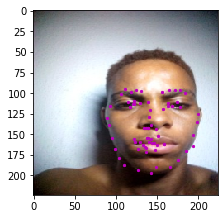

In [107]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
#for i,(x,y,w,h) in enumerate(faces):
for i in range(1):    
    # Select the region of interest that is the face in the image 
    #roi = image_copy[y:y+h, x:x+w]
    roi = image_copy
    roi = cv2.resize(roi, (224,224))
    ## TODO: Convert the face region from RGB to grayscale
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi_gray = roi_gray/255
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi_gry_res = cv2.resize(roi_gray, (224, 224))
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi_gry_res_tch  = tch.from_numpy(roi_gry_res.reshape((224,224,1,1)).transpose((3,2,0,1)))
    img = roi_gry_res_tch.type(torch.FloatTensor)
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    ## perform a forward pass to get the predicted facial keypoints
    output_pts = net(img)
    # reshape to batch_size x 68 x 2 pts
    fac_key = output_pts.view(output_pts.size()[0], 68, -1)[0].data.numpy()*50+100
    #y = lambda x: ( (x-fac_key.min()) * ( (0 - 250) / (fac_key.min() - fac_key.max()) + 0) )
    #fac_key = y(fac_key)
    image2 = np.squeeze(np.copy(img[0].data.numpy().transpose(1,2,0)))
    ## TODO: Display each detected face and the corresponding keypoints 
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(1, 2, i+1)
    plt.tight_layout()
    
    ax.imshow(roi,cmap='gray')
    ax.scatter(fac_key[:,0], fac_key[:,1], s=20, marker='.', c='m')
    #plt.imshow(roi_gry_res, cmap='gray')

In [28]:
len(faces)

43